# Predykcja cen wynajmu mieszkań.

Celem projektu jest stworznie narzędzia, które pozwoli przewidzieć cenę wynajmu mieszkania na podstawie infomacji zawartych w ogłoszeniu. Mam zamiar rowijać projekt używając kolejnych moetody machine learningu. Moim osobistym celem tworzenia projektu jest więc nauka i testowanie modeli w praktyce.

Z rozwojem projektu powiększała się ilość kodu. Dlatego dla przejrzystości szczegóły z poniższych rozdziałów podzieliłem na odrębne pliki. Ten plik zawiera najważniejsze informację z całego projektu.

Spis treści:

1. [Pobranie danych z ogłoszeń wynajmu mieszkań i stworzenie bazy danych.](#1.-Pobranie-danych-z-ogłoszeń-wynajmu-mieszkań-i-stworzenie-bazy-danych.)
2. [Obróbka i analiza danych.](#2.-Obróbka-i-analiza-danych.)
3. [Predykcja cen za pomocą regresji.](#3.-Predykcja-cen-za-pomocą-regresji.)  
  3.1.[Założenia modelu.](https://github.com/pawellachowski777/Apartments/blob/master/regression_assumptions.ipynb)


## 1. Pobranie danych z ogłoszeń wynajmu mieszkań i stworzenie bazy danych.

W myśl zasady DRY, importuję funkcję *adverts* z pliku *my_functions*. Służy ona do pobierania danch z portalu ogłoszeniowego. Szczegóły z tworzenia bazy znajdują się w pliku [web_scrap.ipynb](https://github.com/pawellachowski777/Apartments/blob/master/web_scrap.ipynb).

In [1]:
from datetime import datetime
from my_functions import adverts

In [2]:
now = datetime.now()
print(now.strftime('%d/%m/%Y %H:%M:%S'))

rows = adverts(pages=1)

18/04/2021 13:17:44
pobrano dane z 38 ogłoszeń.


In [3]:
import pandas as pd

base = pd.DataFrame(rows, 
                    columns = ['link', 'dodano', 'miasto', 'dzielnica', 'cena', 'od', 'poziom', 
                               'umeblowanie','zabudowa','powierzchnia', 'pokoje', 'czynsz dodatkowo'])
base.head()

,link,dodano,miasto,dzielnica,cena,od,poziom,umeblowanie,zabudowa,powierzchnia,pokoje,czynsz dodatkowo
0,https://www.olx.pl/oferta/polecam-kawalerka-wo...,18 kwietnia 2021,"Warszawa,",Ochota,1750,Osoby prywatnej,5,1,Blok,22,Kawalerka,1
1,https://www.olx.pl/oferta/mieszkanie-do-wynaje...,18 kwietnia 2021,"Warszawa,",Praga-Południe,2900,Osoby prywatnej,4,1,Blok,64,3,1
2,https://www.olx.pl/oferta/nowoczesne-mieszkani...,18 kwietnia 2021,"Warszawa,",Mokotów,3000,Osoby prywatnej,4,1,Blok,48,2,500
3,https://www.olx.pl/oferta/mieszkanie-wynajem-C...,18 kwietnia 2021,"Warszawa,",Wola,2400,Osoby prywatnej,4,1,Kamienica,45,2,450
4,https://www.olx.pl/oferta/wynajme-mieszkanie-7...,18 kwietnia 2021,"Warszawa,",Mokotów,3700,Osoby prywatnej,1,1,Blok,70,3,700


In [4]:
# base.to_csv('./data/data_with_time.csv', mode='a', index=False, header=False) 

## 2. Obróbka i analiza danych.

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from my_functions import drop_value
from scipy import stats

Surowa baza danych

In [6]:
df_waw = pd.read_excel('.\data\web_scrap.xlsx')
df_waw.head()

,link,miasto,dzielnica,cena,od,poziom,umeblowanie,zabudowa,powierzchnia,pokoje,czynsz dodatkowo
0,https://www.olx.pl/oferta/dwupokojowe-z-oddzie...,"Warszawa,",Targówek,2300,Biuro / Deweloper,2,1,Apartamentowiec,60,2,1
1,https://www.olx.pl/oferta/2-pokoje-bielany-met...,"Warszawa,",Bielany,3000,Osoby prywatnej,3,1,Apartamentowiec,56,2,1
2,https://www.olx.pl/oferta/kawalerka-browary-wa...,"Warszawa,",Śródmieście,2200,Osoby prywatnej,2,1,Apartamentowiec,29,Kawalerka,1
3,https://www.olx.pl/oferta/dwupokojowa-kawalerk...,"Warszawa,",Mokotów,1800,Osoby prywatnej,2,1,Blok,20,2,350
4,https://www.olx.pl/oferta/wynajme-mieszkanie-f...,"Warszawa,",Wawer,2300,Osoby prywatnej,2,1,Apartamentowiec,60,3,500


Wstępne czyszczenie danych wykonałem w pliku [data_clean.ipynb](https://github.com/pawellachowski777/Apartments/blob/master/data_cleaning.ipynb).
Wczytuję plik z obrobionymi tam danymi

In [7]:
df_waw = pd.read_pickle('.\pickle\df_waw_analyse_1.pickle')
df_waw.head()

,dzielnica,od,poziom,umeblowanie,zabudowa,powierzchnia,pokoje,cena całkowita,cena za pokoj
0,Targówek,Biuro / Deweloper,2,1,Apartamentowiec,60,2,2301,1150.500000
1,Bielany,Osoby prywatnej,3,1,Apartamentowiec,56,2,3001,1500.500000
2,Śródmieście,Osoby prywatnej,2,1,Apartamentowiec,29,1,2201,2201.000000
3,Mokotów,Osoby prywatnej,2,1,Blok,20,2,2150,1075.000000
4,Wawer,Osoby prywatnej,2,1,Apartamentowiec,60,3,2800,933.333333


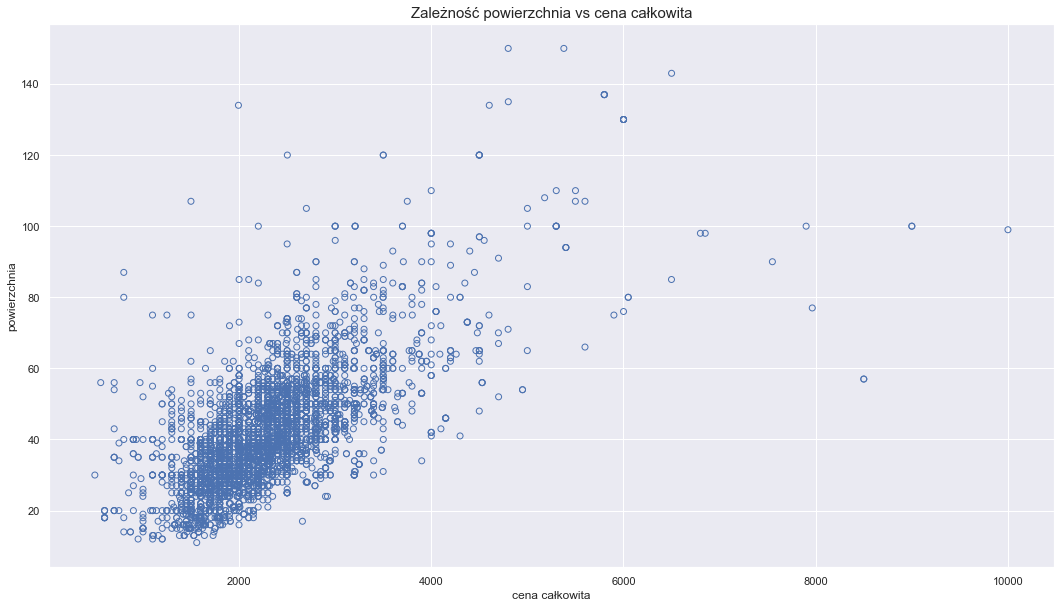

In [8]:
plt.figure(figsize=(18,10))
plt.xlabel('cena całkowita')
plt.ylabel('powierzchnia')
plt.scatter(df_waw['cena całkowita'], df_waw['powierzchnia'], facecolors='none', edgecolors='b')
plt.title('Zależność powierzchnia vs cena całkowita', fontdict={'fontsize':15})
plt.show()

Widać wyraźną, liniową zależność między ceną całkowitą a powierzchnią. Wszystkie wartości skarje zostały już usunięte

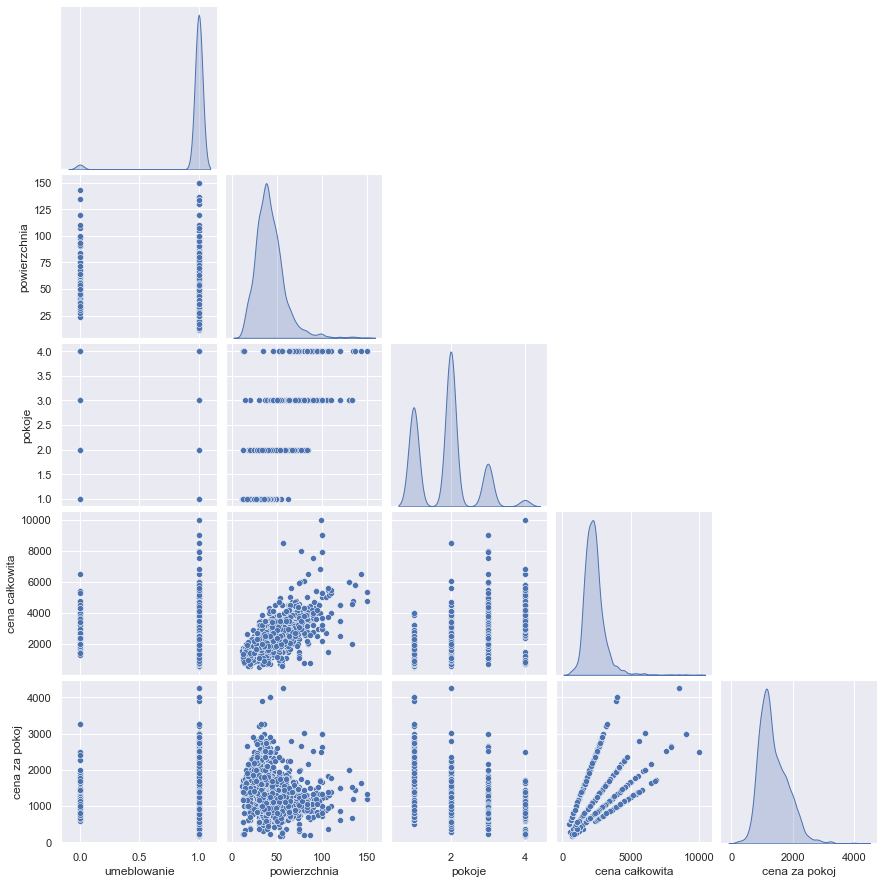

In [9]:
sns.pairplot(df_waw, corner=True, diag_kind='kde')
plt.show()

Wnioski ze wstępnej analizy:  
1. występuje silnia, dodatnia korelacja występuje między ceną całkowitą a powierzchnią,
2. zdecydowana większość mieszkań jest umeblowana,
3. rozkład ceny całkowitej jest silnie skoncentrowany wokół średniej (wysoka kurotza),
4. ciekawie wygląda zależność między powierzchnią a ceną za pokój,
5. dominują mieszkania dwupokojowe i kawalerki.

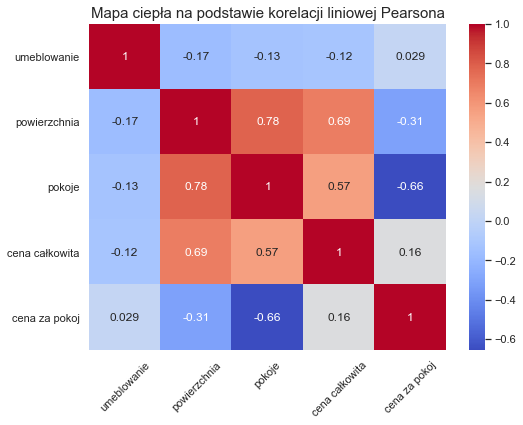

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(df_waw.corr(), cmap='coolwarm', annot=True)
plt.xticks(rotation=45)
plt.title('Mapa ciepła na podstawie korelacji liniowej Pearsona', fontdict={'fontsize':15})
plt.show()

1. Potwierdza się wniosek ze wstępnej analizy, o silnej dodatniej korelacji między ceną całkowitą a powierzchnią.
2. Najsilniej skorelowane są kolumny powierzchnia i liczba pokoi, co wydaje się być dość oczywiste. Należy jednak pamiętać o tym przy tworzeniu modelu, ponieważ zmienne odbaśniające nie mogą być ze sobą skorelowane.
3. Większa liczba pokoi oznacza spadek współczynika cena za pokój. (silna korelacja ujemna). Podobna zależność zachodzi między kolumnami powierzchnia i cena za pokój, jednak korelacja jest słabsza. Im mniejsze mieszkanie, tym więcej płacimy za metr kwadratowy.

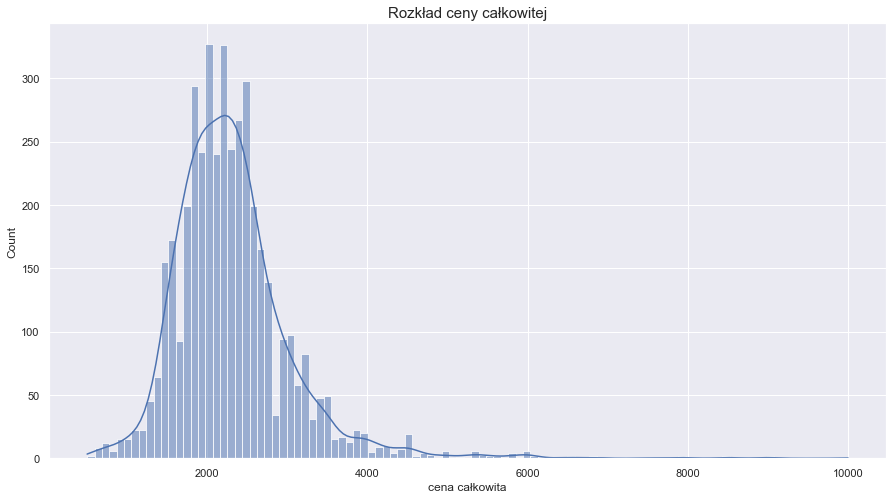

In [11]:
plt.figure(figsize = (15,8))
sns.histplot(df_waw['cena całkowita'], kde=True)
plt.title('Rozkład ceny całkowitej', fontdict={'fontsize':15})
plt.show()

In [12]:
print('''Badanie normalności rozkładu 
H_0 - występuje rokład normalny
H_1 - brak rozkładu normalnego
a = 5%
''')

stat, p = stats.shapiro(df_waw['cena całkowita'])
print(f'p_value: {p:.5f} \n')

if p > 0.05:
    print('Nie ma podstaw do odrzucenia hipotezy zerowej. Występuje rozkład normalny.')
else:
    print('Odrzucamy hipotezę zerową na rzecz hipotezy alternatywnej. Brak rozkładu normalnego.')

Badanie normalności rozkładu 
H_0 - występuje rokład normalny
H_1 - brak rozkładu normalnego
a = 5%

p_value: 0.00000 

Odrzucamy hipotezę zerową na rzecz hipotezy alternatywnej. Brak rozkładu normalnego.


In [13]:
skosnosc = stats.skew(df_waw['cena całkowita'])
kurtoza = stats.kurtosis(df_waw['cena całkowita'])
print(f'Skośność: {skosnosc:.3f} \nKurtoza: {kurtoza:.3f}')

Skośność: 2.285 
Kurtoza: 12.778


Bardzo wysokie skoncentrowanie wartości wokół średniej zaburza normalność rozkładu. Rozkład jest także prawoskośny, więcej niż 50 % jednostek ma wartości mniejsze niż średnia.

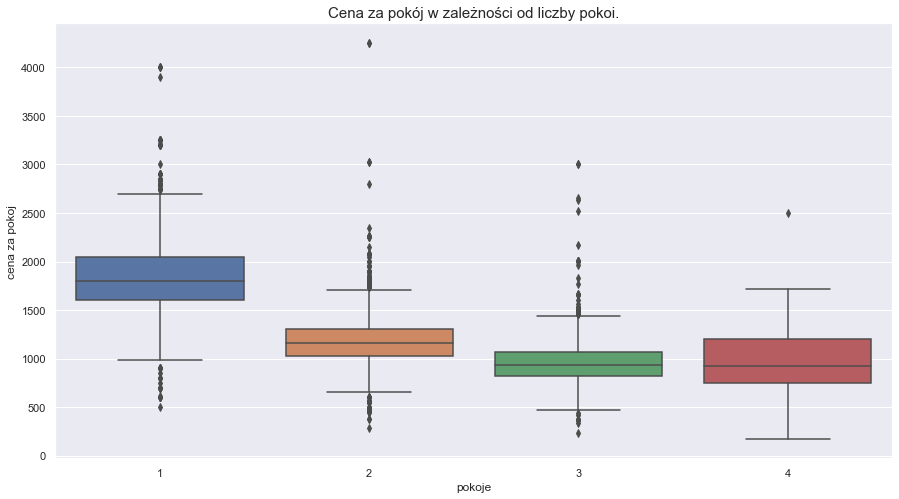

In [14]:
plt.figure(figsize = (15,8))
sns.boxplot(x='pokoje', y='cena za pokoj', data=df_waw)
plt.title('Cena za pokój w zależności od liczby pokoi.', fontdict={'fontsize':15})
plt.show()

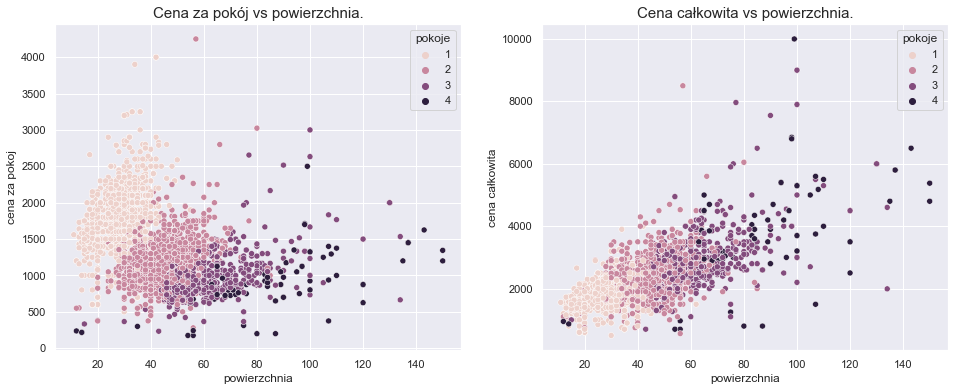

In [15]:
plt.figure(figsize = (16, 6))

plt.subplot(1,2,1)
sns.scatterplot(x=df_waw['powierzchnia'], y = df_waw['cena za pokoj'], hue=df_waw['pokoje'])
plt.title('Cena za pokój vs powierzchnia.', fontdict={'fontsize':15})

plt.subplot(1,2,2)
sns.scatterplot(x=df_waw['powierzchnia'], y = df_waw['cena całkowita'], hue=df_waw['pokoje'])
plt.title('Cena całkowita vs powierzchnia.', fontdict={'fontsize':15})

plt.show()

Wygląda na to, że liczba pokoi jest bardzo dobrze zdefiniowana przez powierzchnię. Dlatego ta informacja (liczba pokoi) w modelu będzie zbędna.

In [16]:
df_waw['powierzchnia na pokoj'] = df_waw['powierzchnia'] / df_waw['pokoje']

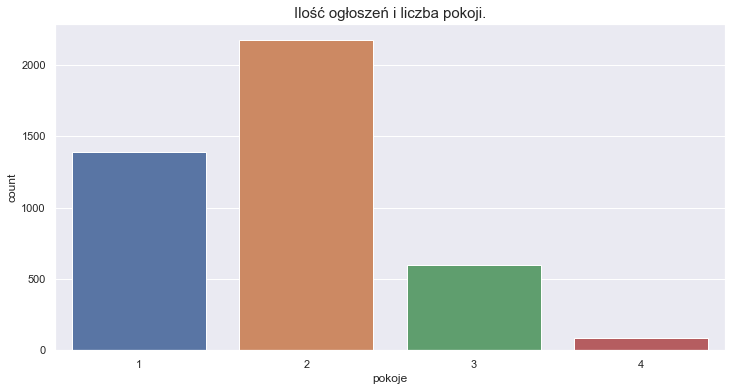

In [17]:
plt.figure(figsize = (12,6))
sns.countplot(x = df_waw['pokoje'])
plt.title('Ilość ogłoszeń i liczba pokoji.', fontdict={'fontsize':15})
plt.show()

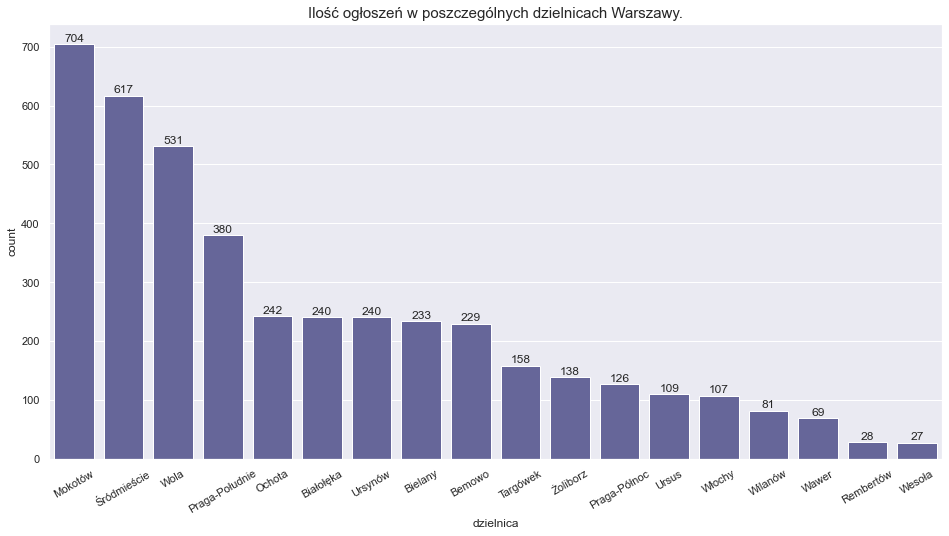

In [18]:
counts = df_waw['dzielnica'].value_counts()

plt.figure(figsize = (16,8))
plt.xticks(rotation=30)
sns.countplot(x = df_waw['dzielnica'], color='blue', saturation=0.2, order=counts.index)
plt.title('Ilość ogłoszeń w poszczególnych dzielnicach Warszawy.', fontdict={'fontsize':15})
for i in range(len(counts)):
    plt.text(i, counts[i]+5, counts[i], ha='center')
plt.show()

Najwięcej ogłoszeń w Warszawie dotyczy dzielnic: Śródmieście, Mokotów, Wola. Dzielnice te można nazwać biznesową częścią miasta. Natomiast w dzielicach z obrzeży Warszawy (Włochy, Wawer, Rembertów, Wesoła), mieszkań do wynajęcia jest o wiele mniej. Tak mała ilość ogłoszeń dla tych dwóch ostatnich może być problemem dla regresji.

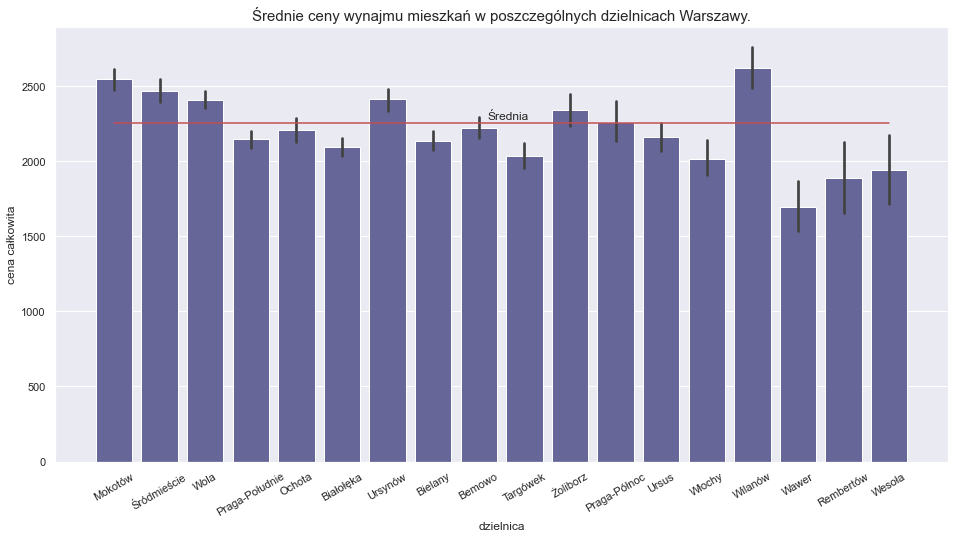

In [19]:
plt.figure(figsize = (16,8))
plt.xticks(rotation=30)
sns.barplot(y='cena całkowita', x='dzielnica', data=df_waw, color='blue', saturation=0.2, order=counts.index)
plt.title('Średnie ceny wynajmu mieszkań w poszczególnych dzielnicach Warszawy.', fontdict={'fontsize':15})
plt.plot([2257,2257]*9, color = 'r') # średnia cena
plt.text(8.2,2280,'Średnia')
plt.show()

Dla dzielnic biznesowych, średnie ceny wynajmu kształtują się powyżej średniej ze wszystkich ogłoszeń. Ponad to, najdroższe mieszkania znajdują się na Wilanowie. Wysoką średnią mają także Żoliborz i Ursynów. Wawer, Rembertów i Wesoła mają ceny dużo poniżej średniej ogólnej.  
Przedziały ufności w 5 ostatnich dzielnicach wydają się być za duże. Oznacza to, że ich wartości mogą znacznie odbiegać od średniej. Przy tworzeniu modelu będę miał to na uwadze. Jeśli okaże się to problemem, pobiorę więcej danych dla tych dzielnic.

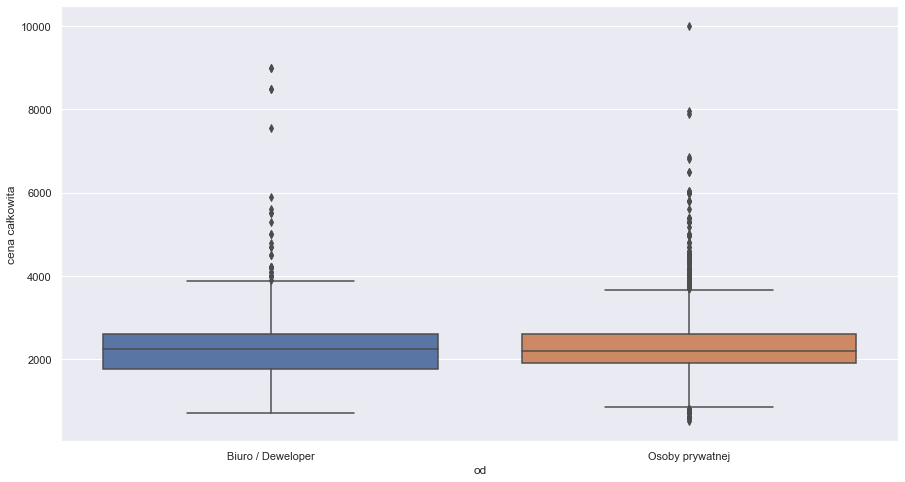

In [20]:
plt.figure(figsize = (15,8))
sns.boxplot(x='od', y='cena całkowita', data=df_waw)
plt.title('', fontdict={'fontsize':15})
plt.show()

Informacja, kto wstawia ogłoszenie, nie wpływa znacząco na cenę mieszkania. Zauważyć można, że ogłoszenia od Deweloperów mają mniej wartości skrajnych. 

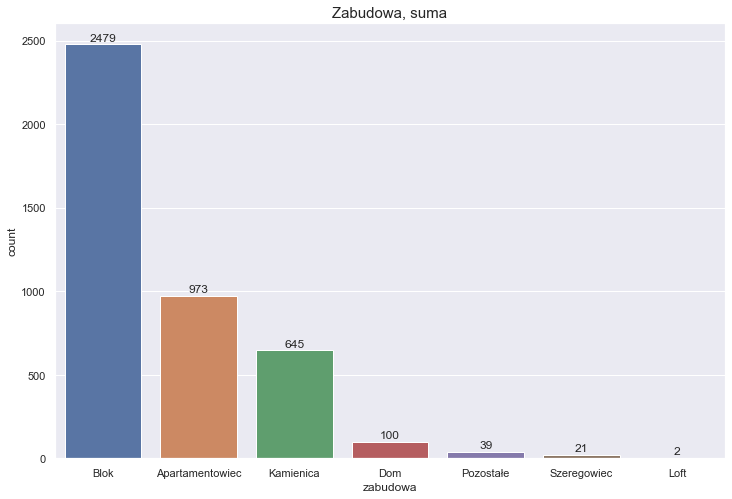

In [21]:
counts = df_waw['zabudowa'].value_counts()

plt.figure(figsize = (12,8))
plt.title('Zabudowa, suma', fontdict={'fontsize':15})
for i in range(len(counts)):
    plt.text(i, counts[i]+20, counts[i], ha='center')
sns.countplot(x=df_waw['zabudowa'], order=counts.index)
plt.show()

Wyrzucę wszystkie ogłoszenia o wartości "Loft" (za mało danych) i "Pozostałe" (wprowadza niejednoznaczność).

In [22]:
drop_value(df_waw, 'zabudowa', 'Loft')
drop_value(df_waw, 'zabudowa', 'Pozostałe')

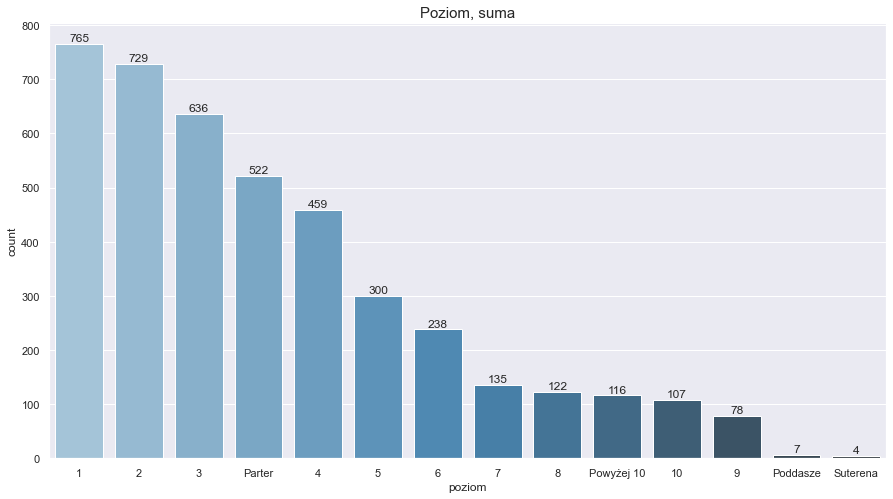

In [23]:
counts = df_waw['poziom'].value_counts()
plt.figure(figsize=(15,8))
for i in range(len(counts)):
    plt.text(i, counts[i]+5, counts[i], ha='center')
plt.title('Poziom, suma', fontdict={'fontsize':15})
sns.countplot(x=df_waw['poziom'], order=counts.index, palette = 'Blues_d')
plt.show()

Wartości "Poddasze" i "Suterena" także powinny być usunięte. Kończąc analizę, usuwam także kolumnę "cena za pokój" i "pokoje".  
Tak obrobione danę zapisuję do pliku *df_waw_analyse_2.pickle*.

In [24]:
df_waw.drop(['cena za pokoj', 'pokoje'], axis = 1, inplace = True)
drop_value(df_waw, 'poziom', 'Suterena')
drop_value(df_waw, 'poziom', 'Poddasze')

df_waw.to_pickle('.\pickle\df_waw_analyse_2.pickle')

## 3. Predykcja cen za pomocą regresji.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import pickle

Szczegóły z przygotowywania danych do regresji w pliku [models_test](https://github.com/pawellachowski777/Apartments/blob/master/models_test.ipynb).

In [26]:
X = pd.read_pickle('./pickle/X.pickle')
y = pd.read_pickle('./pickle/y.pickle')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=60)

X_const = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_const).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:         cena całkowita   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     119.0
Date:                Sun, 18 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:18:12   Log-Likelihood:                -21306.
No. Observations:                2818   AIC:                         4.268e+04
Df Residuals:                    2783   BIC:                         4.289e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1558.5381     62.62

Iterpretacja wyniku regresji:
1. Statystyka R kwadrat jest dość wysoka ok. 60 %. Model w 60 % wyjaśnia cenę wynajmu mieszkania.
2. Uśrednione R kwadrat, uwzględniające ilość stopni swobody, nie odbiega od R kwadrat. Oznacza to, że ilość zmiennych nie wpływa negatywnie na ogólny wynik.
3. p_value (Prob (F-statistic)) jest bliskie 0. Oznacza to, że mnożnik (coefficeint) zmiennych objaśniających jest różny od zera. Innymi słowy, prawdopodobieństwo, że cena wynajmu jest losowa jest bliskie 0.
4. Mnożnik wskazuje, o ile złotych podniesie się cena wynajmu jeśli wartość zmiennej zwiększy się o 1, a pozostałe zmienne będą stałe. W przypadku zmiennych dummies interpretować go trzeba w odniesieniu do kolumny odrzuconej w danym zakresie. Przy interpretacji coef, należy patrzeć także na pozostałe parametry wskazujące na jego wiadrygodniość.
  1. Dla zmiennych utworzonych od "dzielnica" coef wskazuje o ile zmieni się cena mieszkania w tej dzielnicy, w porównaniu do Mokotowa. Mieszkanie na Bemowie będzie średnio o 271 zł tańsze niż na Mokotowie. Problem pojawia się, gdy ceny mieszkań w dzielnicy są zbliżone np. Śródmieśćie. Istnieje wtedy duża szansa (około 60%), że wskaźnik coef będzie się różnił od tego który mamy podany w tabeli. Jednak jak spojrzy się na przedziały ufności, Widać że nie są one szerokie.
  1. Mieszkania usytuowane powyżej 10 piętra są z regóły droższe, podobnie jak apartamentowce.

In [28]:
lm = LinearRegression()
lm.fit(X_train, y_train)
prediction = lm.predict(X_test) 
residuals = prediction - y_test # składniki resztowe

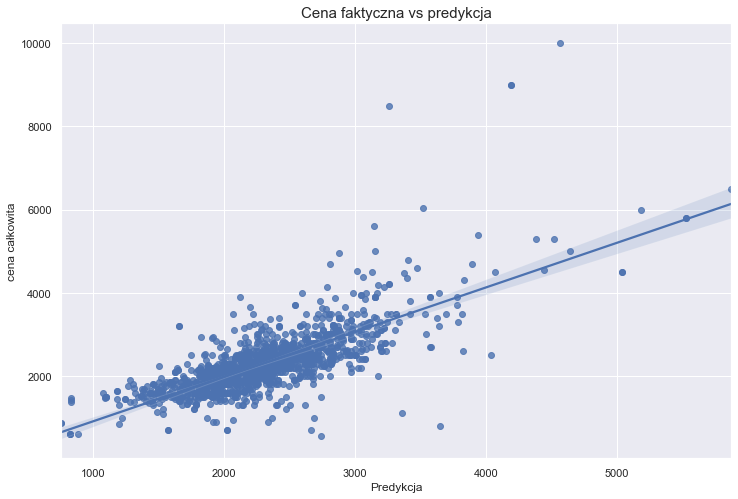

In [29]:
plt.figure(figsize = (12,8))
plt.xlabel('Predykcja')
plt.ylabel('Cena faktyczna')
plt.title('Cena faktyczna vs predykcja', fontdict={'fontsize':15})
sns.regplot(x=prediction, y=y_test)
plt.show()

In [30]:
with open( '.\pickle\linear_model.pickle', 'wb') as writer:
    pickle.dump(lm, writer)

In [31]:
def price_predict(surfance, district, by='Osoby prywatnej', level='1', building='Blok'):
    """
    district: 'Bemowo', 'Białołęka', 'Bielany', 'Ochota', 'Praga-Południe', 'Praga-Północ', 
              'Rembertów', 'Targówek', 'Ursus', 'Ursynów', 'Wawer', 'Wesoła', 'Wilanów', 'Wola', 
              'Włochy', 'Śródmieście', 'Żoliborz', 'Mokotów',
    by: 'Biuro / Deweloper', 'Osoby prywatnej',
    level: '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'Parter', 'Powyżej 10',
    building: 'Blok', 'Kamienica', 'Dom', 'Szeregowiec', 'Apartamentowiec',
    
    To make this function work put the 'linear_model.pickle' file in the folder where you actually are.
    """
    
    import numpy as np
    import pickle 
    
    lm = pickle.load(open('.\pickle\linear_model.pickle', 'rb'))
    
    columns = ['powierzchnia', 'Bemowo', 'Białołęka', 'Bielany', 'Ochota',
               'Praga-Południe', 'Praga-Północ', 'Rembertów', 'Targówek', 'Ursus',
               'Ursynów', 'Wawer', 'Wesoła', 'Wilanów', 'Wola', 'Włochy',
               'Śródmieście', 'Żoliborz', 'Biuro / Deweloper', '1', '10', '2', '3',
               '4', '5', '6', '7', '8', '9', 'Parter', 'Blok', 'Dom', 'Kamienica',
               'Szeregowiec']
    list_district = columns[1:18] # brak Mokotów
    list_level = columns[19:30] # brak powyżej 10
    list_building = columns[30:] # brak apartamentowiec
    values = np.array(surfance)
    
    for dist in list_district:
        if dist == district:
            values = np.append(values, 1)
        else:
            values = np.append(values, 0)

    if by == 'Biuro / Deweloper':
        values = np.append(values, 1)
    else:
        values = np.append(values, 0)

    for lv in list_level:
        if lv == level:
            values = np.append(values, 1)
        else:
            values = np.append(values, 0)
            
    for build in list_building:
        if build == building:
            values = np.append(values, 1)
        else:
            values = np.append(values, 0)
    
    values = values.reshape(1,-1)
    predict = lm.predict(values)
    print(f'Przewidywana cena to {round(predict[0],2)} zł.')
    return predict

In [32]:
val = price_predict(surfance=20, district='Mokotów', by='Osoby prywatnej', level='1', building='Apartamentowiec')

Przewidywana cena to 1895.73 zł.
